In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import re
import utils
import tensorflow as tf
from tensorflow import keras
from glob import glob

In [2]:
TRAIN_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/train'
OUTPUT_SHAPE = (256, 256)

In [3]:
os.listdir('DeepRuleDataset/bardata(1031)/bar/annotations')

['instancesBar(1031)_val2019.json',
 '.DS_Store',
 'instancesBar(1031)_train2019.json',
 'instancesBar(1031)_test2019.json',
 'processed']

In [4]:
# File paths to load JSON files
TRAIN_ANNOTATIONS_ORIGINAL = 'DeepRuleDataset/bardata(1031)/bar/annotations/instancesBar(1031)_train2019.json'
VAL_ANNOTATIONS_ORIGINAL = 'DeepRuleDataset/bardata(1031)/bar/annotations/instancesBar(1031)_val2019.json'
# File paths to load bar images
TRAIN_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/train2019'
VAL_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/val2019'

with open(TRAIN_ANNOTATIONS_ORIGINAL) as f:
        train_annotations = json.load(f)
with open(VAL_ANNOTATIONS_ORIGINAL) as f:
        val_annotations = json.load(f)

train_images = train_annotations['images']
val_images = val_annotations['images']

In [5]:
train_images[0:5]

[{'file_name': '010de2766e1fb3e4899f75bf7c2c3e1f_c3RhdGljLWNvbnRlbnQuc3ByaW5nZXIuY29tCTIzLjYuMTA1LjIxNw==-1-0.png',
  'height': 660,
  'width': 910,
  'id': 0},
 {'file_name': '010e66b87ddb5db07bcca1006d09e6ef_aGVwLnVjc2IuZWR1CTEyOC4xMTEuMTkuMzU=.xls-0-0.png',
  'height': 613,
  'width': 901,
  'id': 1},
 {'file_name': '010e66b87ddb5db07bcca1006d09e6ef_aGVwLnVjc2IuZWR1CTEyOC4xMTEuMTkuMzU=.xls-1-0.png',
  'height': 613,
  'width': 901,
  'id': 2},
 {'file_name': '010fcb58eb927a215aec28834a7a4591_d3d3LmlzcHYuY3oJMjEyLjExMS4yOS4xMDM=.xls-21-0.png',
  'height': 386,
  'width': 597,
  'id': 3},
 {'file_name': '010fcb58eb927a215aec28834a7a4591_d3d3LmlzcHYuY3oJMjEyLjExMS4yOS4xMDM=.xls-22-0.png',
  'height': 416,
  'width': 602,
  'id': 4}]

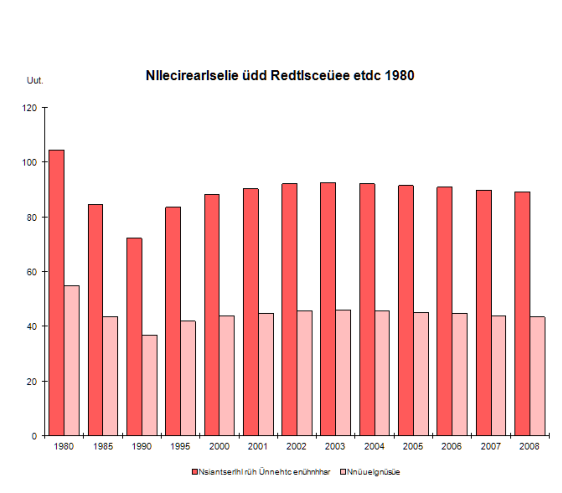

In [6]:
index = 47
file_name = train_images[index]['file_name']
file_path = os.path.join(TRAIN_PATH_BAR, file_name)
rgb = cv2.imread(file_path, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(rgb)
ax.axis('off')
plt.show()

In [7]:
y_axis_line, line_image = utils.extract_y_axis(file_path)

Y-Axis Line Coordinates: ((40, 513), (40, 116))


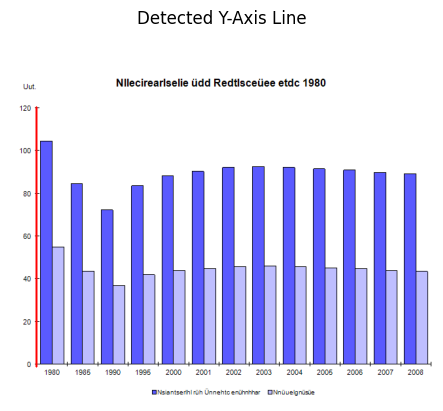

In [8]:
# Display the image with detected lines
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Y-Axis Line')
plt.axis('off')
plt.show()

In [9]:
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
txt = utils.extract_text(gray, y_axis_line)
try:
    y_min, y_max = utils.find_min_max(txt)
except ValueError:
    y_min, y_max = 'Minimum y value not found', 'Maximum y value not found'

print(f'Extracted values: \ny_min - {y_min} \ny_max - {y_max}')

Extracted values: 
y_min - 6 
y_max - 120


### part 2

In [10]:
from tensorflow.keras.models import load_model
from keras.losses import BinaryCrossentropy, Huber

@tf.keras.utils.register_keras_serializable()
def keypoint_loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    huber = Huber(delta=1.0)
    return bce(y_true, y_pred) + huber(y_true, y_pred)

stacked_hourglass = load_model('SavedModels/key-point-detector-epoch-1.keras')
image_paths = [os.path.join(TRAIN_PATH_BAR, image['file_name']) for image in train_images[40:48]]
X = np.array([cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), OUTPUT_SHAPE) for path in image_paths])
predictions = stacked_hourglass.predict(X)

I0000 00:00:1720429887.293556   89179 service.cc:145] XLA service 0x60000102c500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720429887.293572   89179 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-08 14:41:27.330723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720429887.977808   89179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


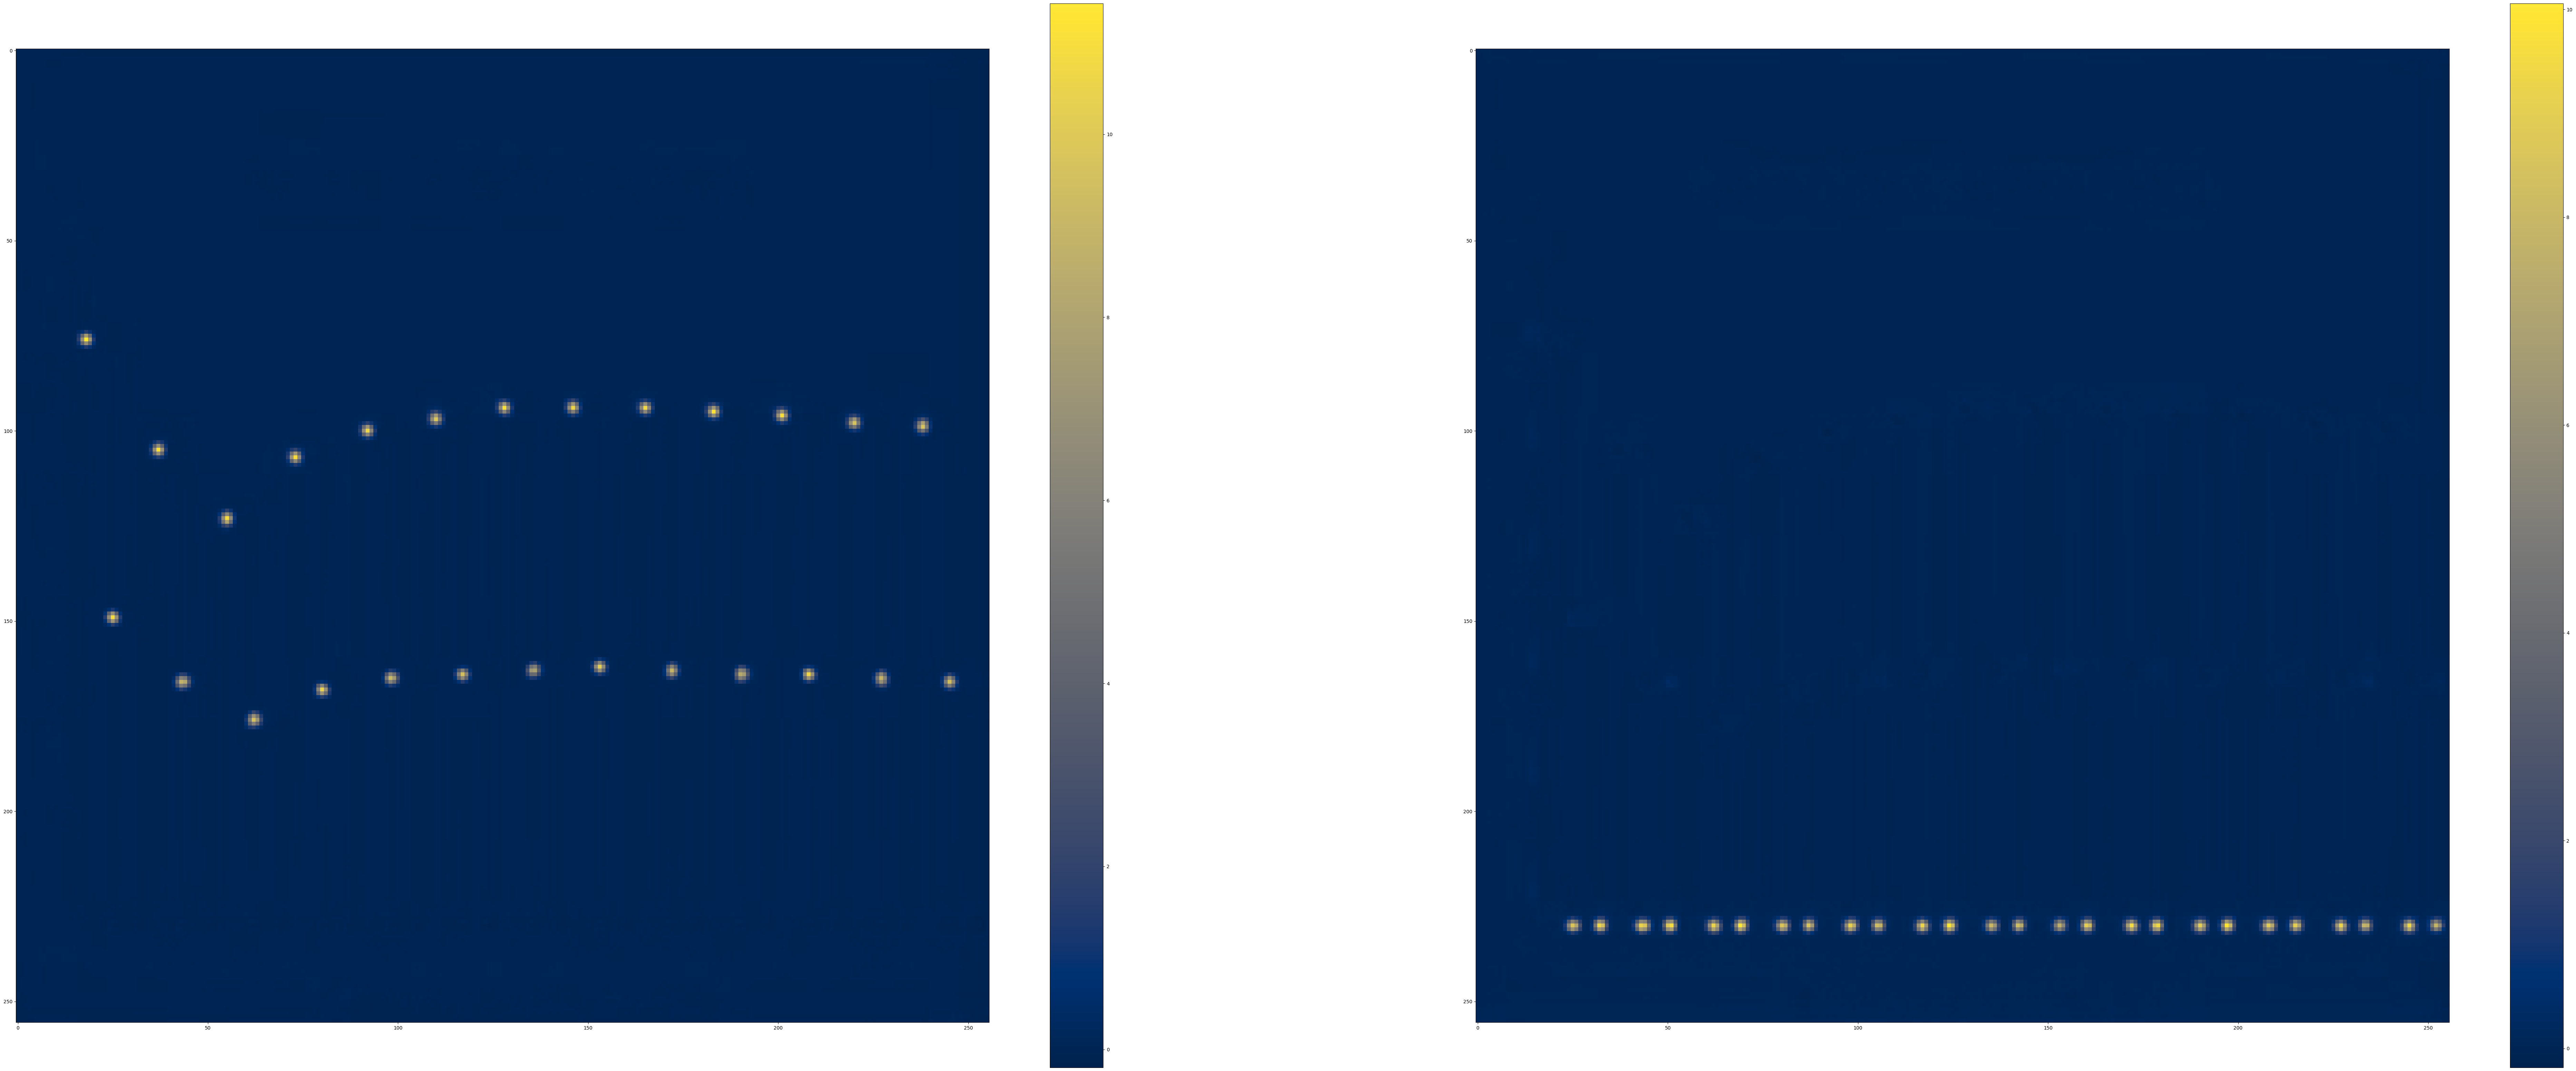

In [11]:
index = 7
predicted_heatmap = predictions[index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

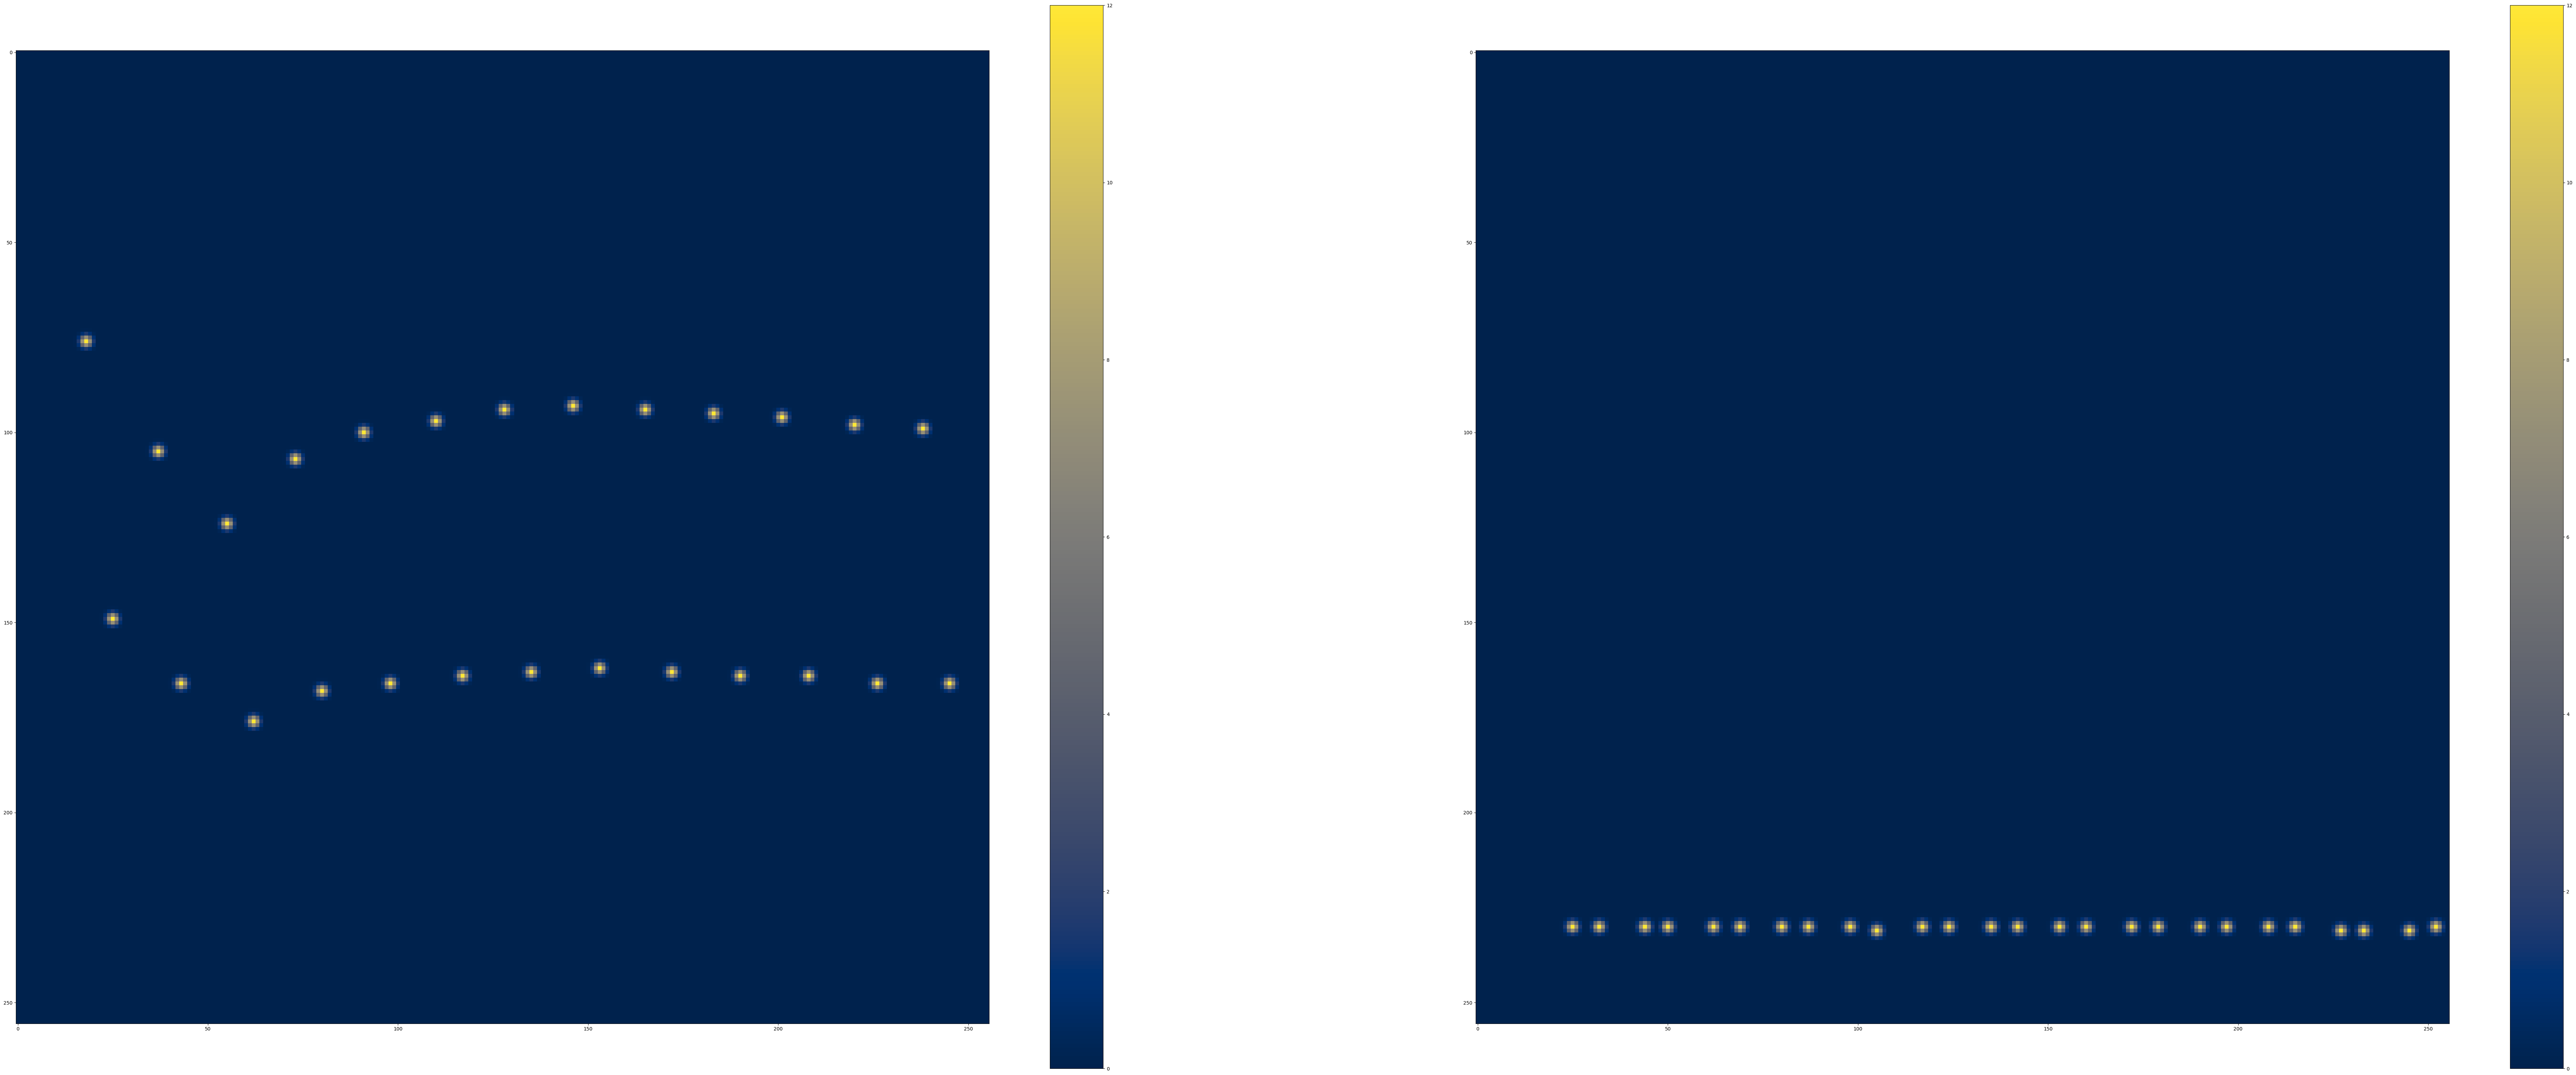

In [12]:
# load two batches of train heatmaps
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))[5:6]
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
train_heatmaps = np.concatenate([np.load(heatmap)['batch'] for heatmap in train_heatmaps], axis=0)
heatmap = train_heatmaps[index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

In [13]:
THRESHOLD = 1
input_img_height = train_images[47]['height']
heatmap_height = OUTPUT_SHAPE[0]
scaling_factor = utils.calculate_scaling_factor(input_img_height, heatmap_height, y_axis_line, y_max)

centroids = utils.extract_centroids(predicted_heatmap,threshold=THRESHOLD)
matched_coordinates = utils.match_bar_coordinates(centroids)
extracted_bar_values = utils.bar_values(matched_coordinates, scaling_factor)    

In [14]:
from prettytable import PrettyTable

table = PrettyTable()
for index, value in enumerate(extracted_bar_values):
    table.add_row([f' Category {str(index+1).zfill(2)}', value])
print(table)

+--------------+---------+
|   Field 1    | Field 2 |
+--------------+---------+
|  Category 01 |   103   |
|  Category 02 |    54   |
|  Category 03 |    84   |
|  Category 04 |    43   |
|  Category 05 |    72   |
|  Category 06 |    36   |
|  Category 07 |    83   |
|  Category 08 |    41   |
|  Category 09 |    88   |
|  Category 10 |    43   |
|  Category 11 |    90   |
|  Category 12 |    44   |
|  Category 13 |    92   |
|  Category 14 |    44   |
|  Category 15 |    92   |
|  Category 16 |    45   |
|  Category 17 |    92   |
|  Category 18 |    45   |
|  Category 19 |    91   |
|  Category 20 |    44   |
|  Category 21 |    90   |
|  Category 22 |    43   |
|  Category 23 |    89   |
|  Category 24 |    43   |
|  Category 25 |    88   |
|  Category 26 |    43   |
+--------------+---------+
